<a href="https://colab.research.google.com/github/wherediddavidgo/multitemporal_RSSA/blob/main/stac_gage_ew_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dataretrieval
from dataretrieval import nwis as nwis
from dataretrieval import wqp
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import datetime
from tqdm import tqdm
from scipy.stats import linregress

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Pair gage ids with effective width point ids

In [3]:
gage_list = ['06801000','06801000','06801000',
             '06800500','06800500','06800500',
             '06805500','06805500','06805500',
             '06800000','06800000','06800000',
             '06775900','06775900','06775900',
             '06620000','06620000','06620000']

points = [201625, # 06801000
          153085,
          201888,
          246043, # 06800500
          246016,
          246048,
          202726, # 06805500
          203066,
          202446,
          120725, # 06800000
          120445,
          120748,
          94011, # 06775900
          93932,
          94005,
          41913, # 06620000
          41900,
          41930]


gage_pts = pd.DataFrame({'gage_id': gage_list,
                         'iindex': points})

u_gage_list = []
for g in set(gage_list):
    u_gage_list.append(g)

gage_pts = pd.merge(gage_pts, gpd.read_file('/content/drive/MyDrive/river_tinder_assets/gage_sites/gage_circles_3x_20250909.shp'), how='outer', on='iindex')[['gage_id', 'iindex', 'riv_length']]
gage_pts

,gage_id,iindex,riv_length
0,06620000,41900,140.711919
1,06620000,41913,142.907272
2,06620000,41930,86.932041
3,06775900,93932,96.207959
4,06775900,94005,140.444539
5,06775900,94011,72.135208
6,06800000,120445,76.595306
7,06800000,120725,148.276448
8,06800000,120748,64.253559
9,06801000,153085,2096.250518


Load in-situ widths from USGS

In [4]:
width_dfs = []
for gage in set(gage_list):
    url = f'https://api.waterdata.usgs.gov/samples-data/results/fullphyschem?mimeType=text%2Fcsv&monitoringLocationIdentifier=USGS-{gage}&characteristicGroup=Physical&characteristicUserSupplied=Width%20of%20stream'

    tempdf = pd.read_csv(url)

    # ws = tempdf[['Location_Identifier', 'Activity_StartDate', 'Result_Measure']]
    width_dfs.append(tempdf)

isw = pd.concat(width_dfs)

isw['site_no'] = isw.apply(lambda x: x['Location_Identifier'].split('-')[1], axis=1)
isw = isw.rename(columns={'Activity_StartDate': 'date', 'Result_Measure': 'width_ft'})
isw['date'] = isw.apply(lambda x: datetime.date(int(x['date'].split('-')[0]), int(x['date'].split('-')[1]), int(x['date'].split('-')[2])), axis=1)
isw['gage_width_m'] = isw.width_ft / 3.28
isw = isw[['date', 'gage_width_m', 'site_no']]

Discharge

In [5]:
sites = ['06620000', '06775900', '06800000', '06800500', '06801000', '06805500']

# first and last dates same as for in situ widths
start = str(isw.sort_values('date').reset_index(drop=True).loc[0, 'date'])
end = str(isw.sort_values('date').reset_index(drop=True).loc[len(isw) - 1, 'date'])

Q = nwis.get_record(sites, service='dv', start=start, end=end).reset_index()

Q['date'] = Q.datetime.dt.date
Q = Q[['site_no', 'date', '00060_Mean']]
Q['00060_Mean'] = Q['00060_Mean'] * (3.28 ** -3)
Q = Q.rename(columns={'00060_Mean': 'Q_cms'})
Q

,site_no,date,Q_cms
0,06620000,2007-11-19,3.967405
1,06620000,2007-11-20,3.740696
2,06620000,2007-11-21,3.485648
3,06620000,2007-11-22,3.230601
4,06620000,2007-11-23,2.862199
...,...,...,...
38989,06805500,2025-08-30,123.556318
38990,06805500,2025-08-31,127.523723
38991,06805500,2025-09-01,181.367072
38992,06805500,2025-09-02,459.085402


Join in-situ width and discharge to build rating curves

In [6]:
cotemporal_wQ = pd.merge(isw, Q, how='inner', on=['site_no', 'date'])
cotemporal_wQ = cotemporal_wQ.loc[cotemporal_wQ.gage_width_m != 0]
cotemporal_wQ['logw'] = np.log10(cotemporal_wQ.gage_width_m)
cotemporal_wQ['logQ'] = np.log10(cotemporal_wQ.Q_cms)
cotemporal_wQ

,date,gage_width_m,site_no,Q_cms,logw,logQ
0,2023-09-06,85.365854,06800500,7.481392,1.931284,0.873982
1,2022-07-12,70.121951,06800500,36.840187,1.845854,1.566322
2,2014-08-06,70.121951,06800500,32.589396,1.845854,1.513076
3,2011-06-13,74.695122,06800500,90.400150,1.873292,1.956169
4,2024-01-23,76.219512,06800500,19.213574,1.882066,1.283608
...,...,...,...,...,...,...
1229,2025-07-07,22.560976,06800000,2.567478,1.353358,0.409507
1230,2025-07-22,16.463415,06800000,5.412674,1.216520,0.733412
1231,2025-08-05,15.243902,06800000,19.326929,1.183096,1.286163
1232,2025-08-18,12.195122,06800000,2.159402,1.086186,0.334333


Build power law rating curves with cotemporal gage w and Q

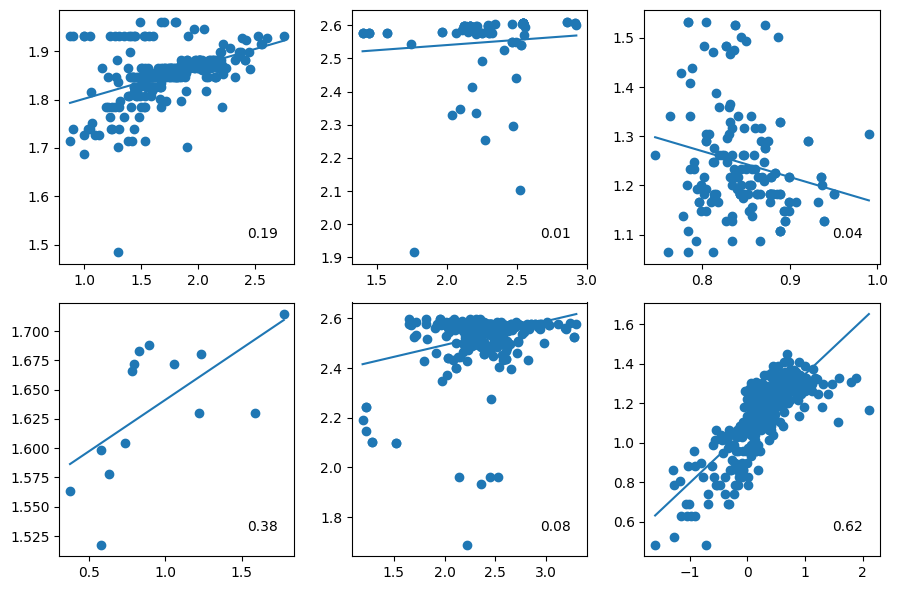

In [12]:
rc_slopes = []
rc_intercepts = []
r2s = []


fig, (axs) = plt.subplots(ncols=3, nrows=2, figsize=(9, 6))
p = 0
for g in set(cotemporal_wQ.site_no.tolist()):

    subset = cotemporal_wQ.loc[cotemporal_wQ.site_no == g]

    slope, intercept, r, pval, _ = linregress(subset.logQ, subset.logw)

    rc_slopes.append(slope)
    rc_intercepts.append(intercept)
    r2s.append(r ** 2)

    ax = axs.flatten()[p]
    # ax.scatter(subset.Q_cms, subset.gage_width_m)
    ax.scatter(subset.logQ, subset.logw)
    rc_x = np.linspace(min(subset.logQ), max(subset.logQ))

    ax.plot(rc_x, rc_x * slope + intercept)
    ax.text(0.8, 0.1, f'{round(r ** 2, 2)}', transform=ax.transAxes)
    p += 1

fig.tight_layout()

In [14]:
rating_curve_parms = pd.DataFrame({'site_no': u_gage_list, 'b': rc_slopes, 'loga': rc_intercepts, 'r2': r2s}).set_index('site_no')
rating_curve_parms['a'] = 10 ** rating_curve_parms.loga
rating_curve_parms

,b,loga,r2,a
site_no,,,,
06800500,0.068638,1.732994,0.186642,54.074626
06801000,0.031141,2.477969,0.008993,300.585898
06775900,-0.528364,1.692555,0.042450,49.266824
06620000,0.087846,1.553382,0.383412,35.758761
06805500,0.095966,2.301501,0.078646,200.216932
06800000,0.275466,1.072538,0.616820,11.817848


Estimate width from rating curve, full join with in-situ widths on date and gage id

In [15]:
Q['rc_width_m'] = Q.apply(lambda x: (rating_curve_parms.loc[x['site_no'], 'a']), axis=1) * (Q.Q_cms ** (Q.apply(lambda x: rating_curve_parms.loc[x['site_no'], 'b'], axis=1)))
Q = pd.merge(Q, isw, how='outer', on=['date', 'site_no'])

Q

,site_no,date,Q_cms,rc_width_m,gage_width_m
0,06620000,2007-11-19,3.967405,40.360700,NaN
1,06775900,2007-11-19,5.979446,19.151163,NaN
2,06800000,2007-11-19,2.116894,14.529724,15.243902
3,06800500,2007-11-19,54.126736,71.116651,NaN
4,06801000,2007-11-19,175.699351,353.079768,NaN
...,...,...,...,...,...
39184,06800000,2025-09-03,2.918876,15.874112,15.853659
39185,06800500,2025-09-03,71.413285,72.482480,73.170732
39186,06800500,2025-09-03,71.413285,72.482480,73.170732
39187,06801000,2025-09-03,239.177827,356.487400,NaN


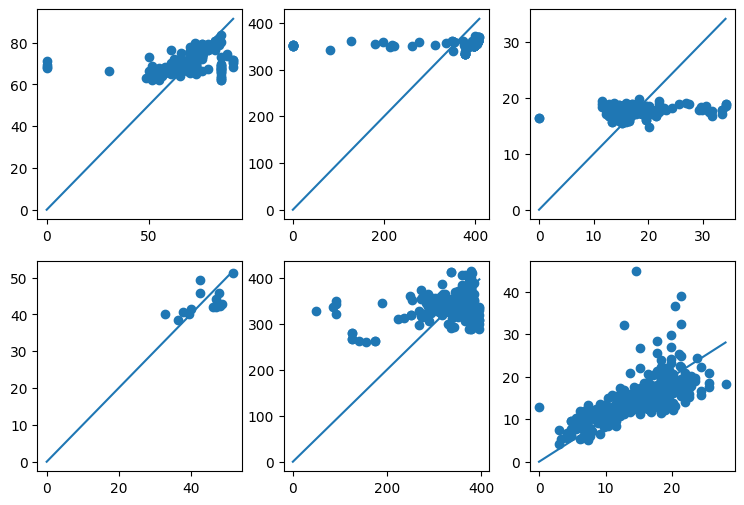

In [16]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(9, 6))

p = 0
for g in u_gage_list:
    subset = Q.loc[Q.site_no == g]
    ax = axs.flatten()[p]
    ax.scatter(subset.gage_width_m, subset.rc_width_m)
    unity = np.linspace(0, (subset.gage_width_m).max(skipna=True))
    ax.plot(unity, unity)
    print()
    p += 1

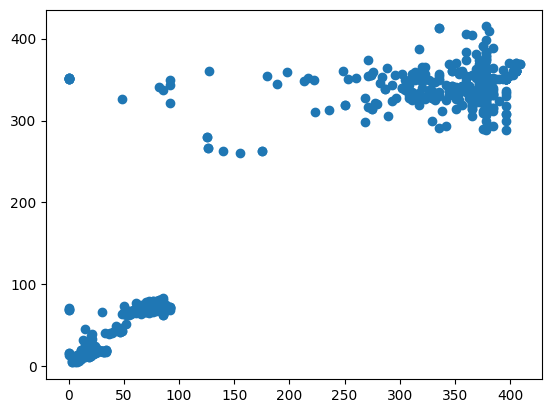

In [17]:
fig, ax = plt.subplots()
ax.scatter(Q.gage_width_m, Q.rc_width_m)

Load in effective width\
See stac_processing_download.ipynb

In [23]:
width_dfs = []
for year in [2018, 2019, 2020, 2021, 2022, 2023, 2024]:
    width_dfs.append(pd.read_csv(f'/content/drive/MyDrive/effwidth_results/gage_sites/gage_effwidths_{year}_20250911_nond.csv'))

allwidths = pd.concat(width_dfs)

allwidths['mgrs'] = allwidths.apply(lambda x: x['img_id'].split('_')[1], axis=1)
allwidths['date'] = allwidths.apply(lambda x: datetime.date(int(x['img_id'][10:14]), int(x['img_id'][14:16]), int(x['img_id'][16:18])), axis=1)
allwidths['version'] = allwidths.apply(lambda x: x['img_id'].split('_')[3], axis=1)

allwidths = allwidths.loc[allwidths.n_valid == allwidths.n_pixels]

allwidths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,mgrs,date,version
0,0,S2B_15TTF_20181229_0_L2A,246043,760,760,16,0,752,15TTF,2018-12-29,0
4,4,S2B_15TTF_20181229_0_L2A,246016,1892,1892,0,0,1792,15TTF,2018-12-29,0
6,6,S2B_15TTF_20181229_0_L2A,246048,1797,1797,22,11,1778,15TTF,2018-12-29,0
7,7,S2B_15TTF_20181229_0_L2A,201625,45736,45736,13965,22851,12294,15TTF,2018-12-29,0
8,8,S2B_14TPM_20181229_0_L2A,120725,164,164,65,22,136,14TPM,2018-12-29,0
...,...,...,...,...,...,...,...,...,...,...,...
1783,1783,S2B_15TTF_20240102_0_L2A,246043,760,760,194,0,0,15TTF,2024-01-02,0
1784,1784,S2B_15TTF_20240102_0_L2A,153085,29425,29425,7011,0,0,15TTF,2024-01-02,0
1787,1787,S2B_15TTF_20240102_0_L2A,246016,1892,1892,401,0,0,15TTF,2024-01-02,0
1789,1789,S2B_15TTF_20240102_0_L2A,246048,1797,1797,284,0,0,15TTF,2024-01-02,0


AWS S2 STAC holds duplicate versions of some images with different versions of the processing baseline. Identify tiles and dates with multiple images and select the one with the most up to date processing baseline.

In [24]:
tile_dts = []
tile_dt_versions = []
for row in tqdm(allwidths.iterrows()):
    tile = row[1]['mgrs']
    dt = row[1]['date']
    version = row[1]['version']
    tile_dts.append((tile, dt))
    tile_dt_versions.append((tile, dt, version))

tile_dt_version_df = pd.DataFrame(set(tile_dt_versions), columns=['mgrs', 'date', 'version']).sort_values('date')
nonduplicates = []

for combo in tqdm(set(tile_dts)):
    temp_mgrs = combo[0]
    temp_dt = combo[1]
    temp_df = tile_dt_version_df.loc[(tile_dt_version_df.mgrs == temp_mgrs) & (tile_dt_version_df.date == temp_dt)]\
        .sort_values('version', ascending=False)\
        .reset_index()

    df_out = (temp_df.head(1))
    nonduplicates.append(df_out)


nonduplicates = pd.concat(nonduplicates)
nonduplicates

13598it [00:00, 13910.26it/s]
100%|██████████| 2304/2304 [00:04<00:00, 575.36it/s]


,index,mgrs,date,version
0,2665,14TPM,2024-07-10,0
0,1793,14TLM,2019-03-17,0
0,1673,14TQM,2021-02-03,0
0,2960,14TQL,2018-11-06,0
0,628,15TTF,2019-01-08,0
...,...,...,...,...
0,2266,14TQL,2020-02-14,1
0,1242,14TQM,2021-11-23,1
0,1052,14TQL,2024-09-15,0
0,1412,14TPM,2023-04-12,0


Join nonduplicate images with widths and gage ids

In [25]:
nondup_widths = pd.merge(allwidths, nonduplicates[['mgrs', 'date', 'version']], 'right', on=['mgrs', 'date', 'version'])
nondup_widths = pd.merge(nondup_widths, gage_pts, how='left', on='iindex')

nondup_widths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,mgrs,date,version,gage_id,riv_length
0,1065,S2B_14TPM_20240710_0_L2A,120725,164,164,32,0,0,14TPM,2024-07-10,0,06800000,148.276448
1,1066,S2B_14TPM_20240710_0_L2A,120445,42,42,14,0,0,14TPM,2024-07-10,0,06800000,76.595306
2,1067,S2B_14TPM_20240710_0_L2A,120748,42,42,15,0,0,14TPM,2024-07-10,0,06800000,64.253559
3,2522,S2A_14TLM_20190317_0_L2A,94011,42,42,8,15,0,14TLM,2019-03-17,0,06775900,72.135208
4,2523,S2A_14TLM_20190317_0_L2A,94005,135,135,31,55,0,14TLM,2019-03-17,0,06775900,140.444539
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,1109,S2B_15TTF_20230527_0_L2A,246043,760,760,199,142,0,15TTF,2023-05-27,0,06800500,372.624481
10014,1110,S2B_15TTF_20230527_0_L2A,153085,29425,29425,6931,857,0,15TTF,2023-05-27,0,06801000,2096.250518
10015,1113,S2B_15TTF_20230527_0_L2A,246016,1892,1892,391,79,0,15TTF,2023-05-27,0,06800500,585.969546
10016,1115,S2B_15TTF_20230527_0_L2A,246048,1797,1797,277,245,0,15TTF,2023-05-27,0,06800500,552.315562


Calculate effective width and fractions of cloud and snow

In [26]:
nondup_widths['sat_width_m'] = nondup_widths.n_river * 100 / nondup_widths.riv_length
nondup_widths['fraction_cloud'] = nondup_widths.n_cloud / nondup_widths.n_pixels
nondup_widths['fraction_snow'] = nondup_widths.n_snow / nondup_widths.n_pixels
nondup_widths

,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,mgrs,date,version,gage_id,riv_length,sat_width_m,fraction_cloud,fraction_snow
0,1065,S2B_14TPM_20240710_0_L2A,120725,164,164,32,0,0,14TPM,2024-07-10,0,06800000,148.276448,21.581310,0.000000,0.0
1,1066,S2B_14TPM_20240710_0_L2A,120445,42,42,14,0,0,14TPM,2024-07-10,0,06800000,76.595306,18.277883,0.000000,0.0
2,1067,S2B_14TPM_20240710_0_L2A,120748,42,42,15,0,0,14TPM,2024-07-10,0,06800000,64.253559,23.345010,0.000000,0.0
3,2522,S2A_14TLM_20190317_0_L2A,94011,42,42,8,15,0,14TLM,2019-03-17,0,06775900,72.135208,11.090285,0.357143,0.0
4,2523,S2A_14TLM_20190317_0_L2A,94005,135,135,31,55,0,14TLM,2019-03-17,0,06775900,140.444539,22.072770,0.407407,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10013,1109,S2B_15TTF_20230527_0_L2A,246043,760,760,199,142,0,15TTF,2023-05-27,0,06800500,372.624481,53.404972,0.186842,0.0
10014,1110,S2B_15TTF_20230527_0_L2A,153085,29425,29425,6931,857,0,15TTF,2023-05-27,0,06801000,2096.250518,330.637962,0.029125,0.0
10015,1113,S2B_15TTF_20230527_0_L2A,246016,1892,1892,391,79,0,15TTF,2023-05-27,0,06800500,585.969546,66.727017,0.041755,0.0
10016,1115,S2B_15TTF_20230527_0_L2A,246048,1797,1797,277,245,0,15TTF,2023-05-27,0,06800500,552.315562,50.152489,0.136338,0.0


Join rating curve width, gage width, and sat width on date

In [27]:
alldata = pd.merge(Q, nondup_widths, how='outer', right_on=['date', 'gage_id'], left_on=['date', 'site_no'])
alldata

,site_no,date,Q_cms,rc_width_m,gage_width_m,Unnamed: 0,img_id,iindex,n_pixels,n_valid,n_river,n_cloud,n_snow,mgrs,version,gage_id,riv_length,sat_width_m,fraction_cloud,fraction_snow
0,06620000,2007-11-19,3.967405,40.360700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06775900,2007-11-19,5.979446,19.151163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06800000,2007-11-19,2.116894,14.529724,15.243902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06800500,2007-11-19,54.126736,71.116651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06801000,2007-11-19,175.699351,353.079768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47444,06800000,2025-09-03,2.918876,15.874112,15.853659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47445,06800500,2025-09-03,71.413285,72.482480,73.170732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47446,06800500,2025-09-03,71.413285,72.482480,73.170732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47447,06801000,2025-09-03,239.177827,356.487400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


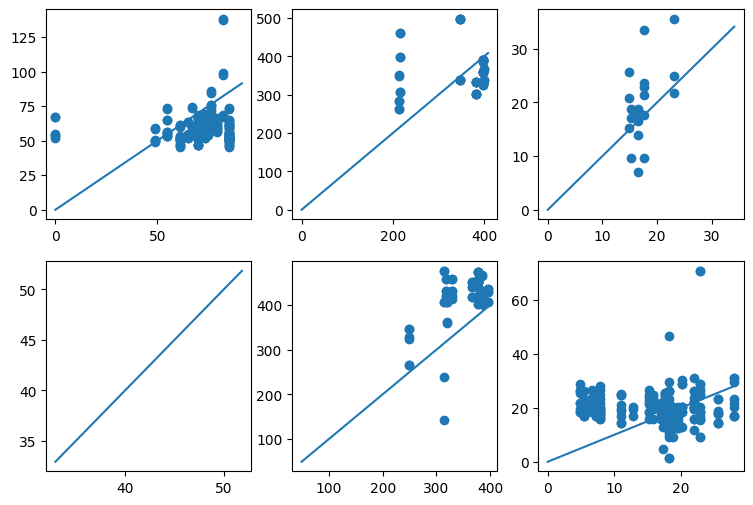

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
p = 0
for g in u_gage_list:
    subset = alldata.loc[alldata.site_no == g]
    sameday = alldata.loc[(alldata.gage_width_m != None) & (alldata.site_no == g)]
    ax = axs.flatten()[p]

    ax.scatter(sameday.gage_width_m, sameday.sat_width_m)
    unity = np.linspace(sameday.gage_width_m.min(), sameday.gage_width_m.max())
    ax.plot(unity, unity)
    p += 1

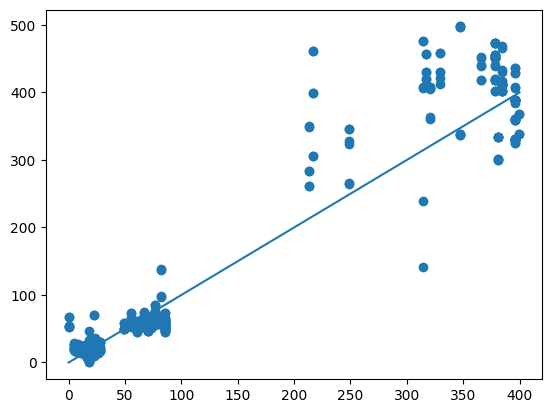

In [30]:
fig, ax = plt.subplots()
sameday = alldata.loc[alldata.gage_width_m != None]
ax.scatter(sameday.gage_width_m, sameday.sat_width_m)
unity = np.linspace(0, 400)
ax.plot(unity, unity)

In [ ]:
unity

array([59.13773316, 59.8441198 , 60.55050643, 61.25689307, 61.9632797 ,
       62.66966634, 63.37605297, 64.08243961, 64.78882624, 65.49521288,
       66.20159951, 66.90798615, 67.61437278, 68.32075942, 69.02714605,
       69.73353269, 70.43991932, 71.14630596, 71.85269259, 72.55907923,
       73.26546586, 73.9718525 , 74.67823913, 75.38462577, 76.0910124 ,
       76.79739904, 77.50378567, 78.21017231, 78.91655894, 79.62294558,
       80.32933222, 81.03571885, 81.74210549, 82.44849212, 83.15487876,
       83.86126539, 84.56765203, 85.27403866, 85.9804253 , 86.68681193,
       87.39319857, 88.0995852 , 88.80597184, 89.51235847, 90.21874511,
       90.92513174, 91.63151838, 92.33790501, 93.04429165, 93.75067828])